In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
TWOPI = 2 * np.pi

In [73]:
# create a 2D dataset to make things simpler

def polar_to_cartesian(vec):
    r = vec[:, 0]
    theta = vec[:, 1]
    return np.array([r * np.cos(theta), r * np.sin(theta)]).T

def window(r):
    radius = np.sqrt(r[:, 0]**2 + r[:, 1]**2)
    return r[radius <= 1]

N_cluster = 200
N_c = 10 # points per cluster
clusters = np.array([np.random.uniform(size=N_cluster), np.random.uniform(size=N_cluster) * TWOPI]).T
clusters = polar_to_cartesian(clusters)

data = np.zeros((N_cluster * N_c, 2))
var = 0.0001
for c in range(N_cluster):
    data[c * N_c: (c + 1) * N_c] = np.random.multivariate_normal(mean=clusters[c], cov=var * np.eye(2), size=N_c)

uniform_data = np.random.uniform(-1, 1, size=(N_cluster * N_c, 2)) # homogeneous poisson point process
    
# apply the window function
data = window(data)
data_u = window(uniform_data)

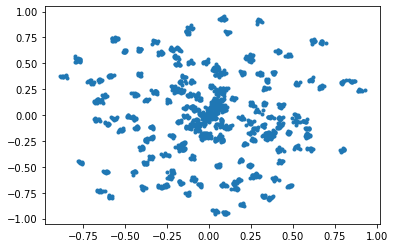

In [74]:
plt.scatter(data[:, 0], data[:, 1], marker=".")

## Pseudo pixelization (Tegmark 1995)

We apply a pixelization scheme $\mathbf{r}_i$ that will reduce the sidelob effect in k-space

That is, we work with the overdensity estimators
$$
    z_i = \int_V \varphi_i(\mathbf{r}) [n(\mathbf{r}) - \bar{n}(\mathbf{r})] d^2r
$$
where $\varphi_i$ are symmetric basis function, usually selected to be gaussian, $n(\mathbf{r})$ is the counting function of the sample and $\bar{\mathbf{n}}$ is the same function but counting over 
$$
    \varphi_i = \propto \exp \left[ -\frac{1}{2} \frac{||\mathbf{r} -\mathbf{r}_i||^2}{\sigma^2_i}\right]
$$
where the $\sigma_i$ are selected to be slightly greater than the neighboring points $r_i$. Also, one should choose points more sparsly in the outskirt of the survey.

Here, the selection function $n(\mathbf{r})$ is defined as

(-0.9842105263157894,
 0.9842105263157894,
 -0.9842105263157894,
 0.9842105263157894)

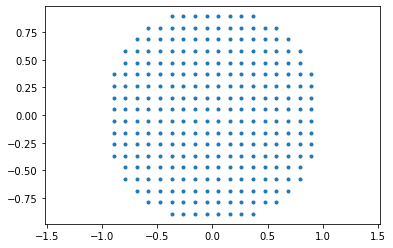

In [75]:
# pixelization -> compute position of the center of each pixel
N_i = 20
ell = 2 / N_i # side length of a pixel
x = np.linspace(-1, 1, N_i)
grid_x, grid_y = np.meshgrid(x, x)
grid = np.column_stack([grid_x.flatten(), grid_y.flatten()]) # get a coordinate array
grid = window(grid) 
plt.scatter(grid[:, 0], grid[:, 1], marker=".")
plt.axis("equal")

In [76]:
# pixel count -> count the number of marks in a pixel
# for a square pixel, this means the position of a given mark fall inside
def square_pixel_count(r, r_i, ell):
    # r: position of the marks
    # r_i: position of the center of each pixel
    right_condition =  r[np.newaxis, :, 0] < r_i[:, np.newaxis, 0] + ell/2
    left_condition = r[np.newaxis, :, 0] > r_i[:, np.newaxis, 0] - ell/2
    up_condition = r[np.newaxis, :, 1] < r_i[:, np.newaxis, 1] + ell/2
    down_condition = r[np.newaxis, :, 1] > r_i[:, np.newaxis, 1] - ell/2
    return (right_condition * left_condition * up_condition * down_condition).sum(axis=1)

In [77]:
count = square_pixel_count(data, grid, ell)
count_u = square_pixel_count(data_u, grid, ell)

## Cell count analysis (Efstathiou 1990 and 1995, MNRAS)

We want to compute the variance excess above Poisson noise

$$
    \bar{N} = \frac{1}{N_p}\sum_{i }N_i
$$
where $N_p$ is the number of pixels. To compute the excess variance, we computer the variance of the data minus the variance of a poisson statistic (equals the mean)
$$
    S = \frac{1}{N_p - 1} \sum_{i}(N_i - \bar{N})^2 - \bar{N}
$$

In [78]:
N_bar = count.mean()
excess_variance = count.var(ddof=1) - N_bar
excess_variance

100.44906455862977

In [79]:
N_bar_u = count_u.mean()
excess_variance_u = count_u.var(ddof=1) - N_bar_u
excess_variance_u

-0.10118577075098756

4.786231884057971

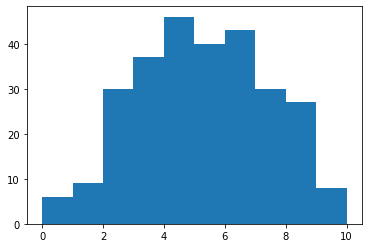

In [80]:
plt.hist(count_u)
N_bar_u

# Power spectra

Test some power spectra method

In [81]:
image, bin_x, bin_y = np.histogram2d(data[:, 0], data[:, 1], bins=100)
image_u, bin_x, bin_y = np.histogram2d(data_u[:, 0], data_u[:, 1], bins=100)

In [82]:
# first, test power_spectra from fft2
def power_spectra_from_image(image):
    n = image.shape[0]
    i_hat = np.fft.fft2(image)
    f = np.fft.fftfreq(n) * n # pixel frequency
    freq_x, freq_y = np.meshgrid(f, f)
    fnorm = np.sqrt(freq_x**2 + freq_y**2).flatten()
    f_amp = np.abs(i_hat).flatten()**2

    # we compute the average power spectra in each bin
    kbins = np.arange(0.5, n//2 + 0.5, 1.) # edge of kbins
    kvals = 0.5 * (kbins[1:] + kbins[:-1]) # actual value of the kbin
    Abins, _, _ = binned_statistic(fnorm, f_amp,
                                         statistic = "mean",
                                         bins = kbins)
    # Abins is only the average power spectra, we need to multiply by the volume in kspace
    Abins *= 4 * np.pi / 3 * (kbins[1:]**3 - kbins[:-1]**3)
    return kvals, Abins

Text(0, 0.5, 'P')

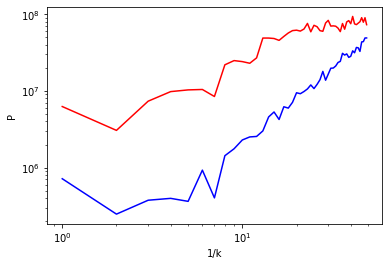

In [83]:
k, P = power_spectra_from_image(image)
k_u, P_u = power_spectra_from_image(image_u)
plt.plot(k, P, "-r")
plt.plot(k_u, P_u, "-b")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("1/k")
plt.ylabel("P")

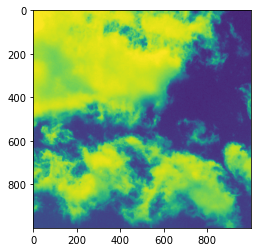

In [84]:
import matplotlib.image as mpimg

image_c = mpimg.imread("clouds.png")
plt.imshow(image_c)

In [85]:
k_c, P_c = power_spectra_from_image(image_c)

Text(0.5, 1.0, 'cloud')

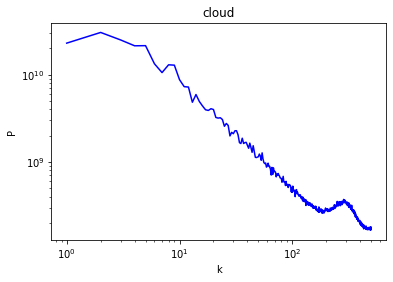

In [86]:
plt.plot(k_c, P_c, "-b")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("P")
plt.title("cloud")

# Correlation function and power spectra of the correlation function

A first idea of an estimator is
$$
    \xi(r) = \frac{\langle n(\mathbf{r}) n(\mathbf{r} + r) \rangle}{\langle n \rangle^2} - 1
$$

In [87]:
N_pixel = count.size
pair_pixel_product = np.zeros(N_pixel * (N_pixel  - 1)//2)
pair_distance = np.zeros(N_pixel  * (N_pixel  - 1)//2)
pair_pixel_product_u = np.zeros(N_pixel * (N_pixel  - 1)//2)


k = 0
for i in range(N_pixel):
    for j in range(i + 1, N_pixel):
        pair_pixel_product[k] = count[i] * count[j]
        pair_pixel_product_u[k] = count_u[i] * count_u[j]
        d = grid[i] - grid[j]
        pair_distance[k] = np.sqrt(d.T @ d)
        k += 1

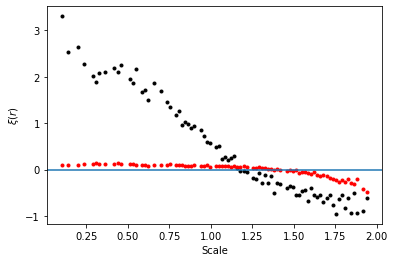

In [88]:
correlation_estimator, bin_edge, bin_number = binned_statistic(x=pair_distance, values=pair_pixel_product, bins=100)
correlation_estimator_u, bin_edge, bin_number = binned_statistic(x=pair_distance, values=pair_pixel_product_u, bins=100)
normalization = np.nanmean(correlation_estimator_u)

plt.plot(bin_edge[:-1], correlation_estimator/normalization - 1, ".k")
plt.plot(bin_edge[:-1], correlation_estimator_u/normalization - 1, ".r")
plt.xlabel("Scale")
plt.ylabel(r"$\xi(r)$")
# plt.yscale("log")
# plt.ylim(None, 2)
# plt.xscale("log")
plt.axhline(0)

# Davis and Peebles (1983) estimator of $\xi(r)$

$$
  \xi(r) = \frac{n_R}{n_D}\frac{\text{DD}}{\text{DR}} - 1  
$$
where
- $DR$ is the count of pairs of galaxies as a function of separation in the random catalog
- $DR$ count of pairs of galaxies between the data and the random catalog, as a function of separation
- $n_D$ and $n_r$ are mean number densities

# Hamilton (1993) estrimator
$$
    \xi(r) = \frac{\text{DD}\,\, \text{RR}}{\text{DR}^2} - 1
$$
where
- $RR$ is the count of pairs of galaxies in the random catalog

# Landy & Szalay (1993) estimator
$$
    \xi(r) = \frac{1}{\text{RR}}\left( \text{DD} \left(\frac{n_R}{n_D} \right)^2 - 
        2 \text{DR} \left(\frac{n_R}{n_D}\right)  + \text{RR} \right)
$$

In [89]:
# lets compute all pairs distance in the dataset
N = data.shape[0]
N_u = data_u.shape[0]
pair_distance = np.zeros(N * (N - 1) // 2)
pair_distance_u = np.zeros(N_u * (N_u - 1) // 2)
pair_distance_dr = np.zeros(N_u * N)
k = 0
#DD
for i in range(N):
    for j in range(i + 1, N):
        d = data[i] - data[j]
        pair_distance[k] = np.sqrt(np.dot(d, d))
        k += 1

#DR
k=0
for i in range(N):
    for j in range(N_u):
        d = data[i] - data_u[j]
        pair_distance_dr[k] = np.sqrt(np.dot(d, d))
        k += 1

# RR
k = 0
for i in range(N_u):
    for j in range(i + 1, N_u):
        d = data_u[i] - data_u[j]
        pair_distance_u[k] = np.sqrt(np.dot(d, d))
        k += 1

Text(0, 0.5, '$\\xi(r)$')

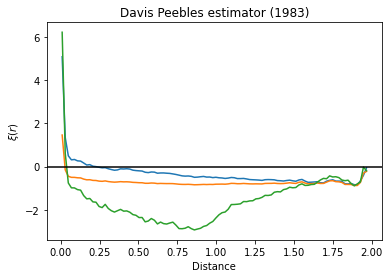

In [96]:
V = np.pi # area of the survey
n_D = N / V
n_R = N_u / V
DD, bin_edges = np.histogram(pair_distance, bins=100)
DR, bin_edges_dr = np.histogram(pair_distance_dr, bins=100)
RR, bin_edges_u = np.histogram(pair_distance_u, bins=100)
xi_davis_peebles = n_R / n_D * DD / DR - 1
xi_hamilton = DD * RR / DR**2 - 1
xi_landy_szalay = (DD * (n_R/n_D)**2 - 2 * DR * (n_R/n_D) + RR)/RR
distance = bin_edges[1:] + bin_edges[:-1]
distance /= 2
plt.plot(distance, xi_davis_peebles)
plt.plot(distance, xi_hamilton)
plt.plot(distance, xi_landy_szalay)
plt.axhline(0, color="k")
# plt.xlim(0, 0.1)
plt.title("Davis Peebles estimator (1983)")
plt.xlabel("Distance")
plt.ylabel(r"$\xi(r)$")

# Ripley K and L estimator

$$
    \hat{K} = \frac{V}{n^2}\sum_{i \not= j} e_i^{-1}(t) I_{\{D(\mathbf{r_i}, \mathbf{r}_i) \leq t \}}
$$
where $e_i(t)$ is the edge correction term.

The L estimator take sinto account that $K$ must vary approximately like $\pi t^2$ for a Poisson point process. therefore, 
$$
    \hat{L} = \sqrt{\frac{\hat{K}(t)}{\pi}}
$$
should vary as $t$, and $\hat{L} - t$ should be zero for a poisson point process.

In [91]:
t = np.linspace(0.001, 2, 200)
V = np.pi
n = N / V
n_u = N_u / V
ripley_K = V / n**2  * (pair_distance[:, np.newaxis] < t).sum(axis=0)
ripley_K_u = V / n**2  * (pair_distance_u[:, np.newaxis] < t).sum(axis=0)
ripley_L = np.sqrt(ripley_K / np.pi)
ripley_L_u = np.sqrt(ripley_K_u / np.pi)

Text(0, 0.5, '$\\hat{K}$')

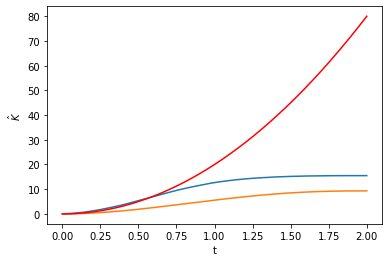

In [92]:
plt.plot(t, ripley_K)
plt.plot(t, ripley_K_u)
plt.plot(t, t**2 * 20, "-r")
plt.xlabel("t")
plt.ylabel(r"$\hat{K}$")
# plt.xscale("log")
# plt.yscale("log")

there are strong edge effects for t > 0.25

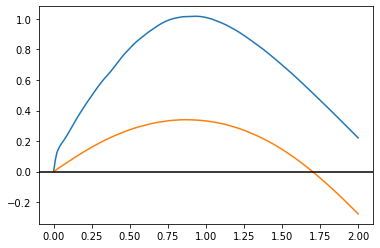

In [93]:
plt.plot(t, ripley_L - t)
plt.plot(t, ripley_L_u - t)
plt.axhline(0, color="k")